In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


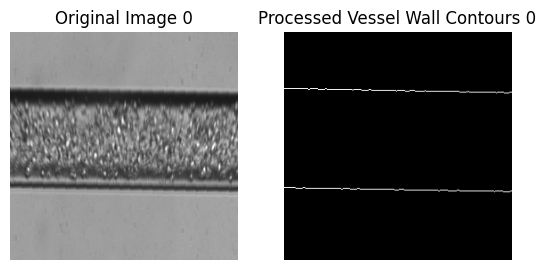

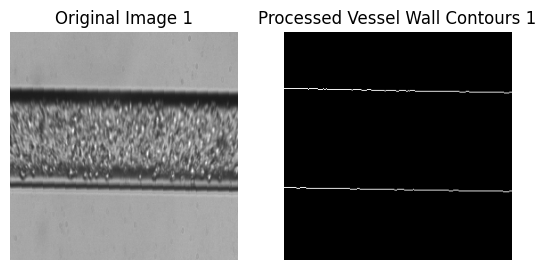

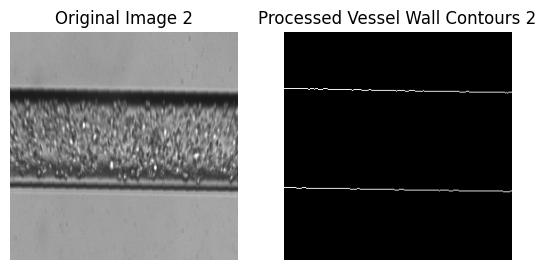

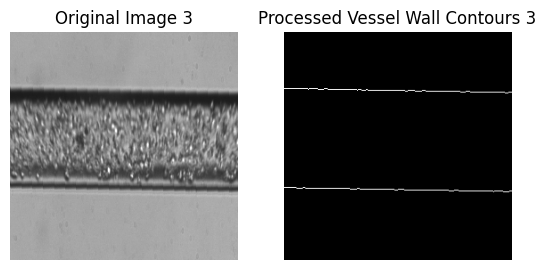

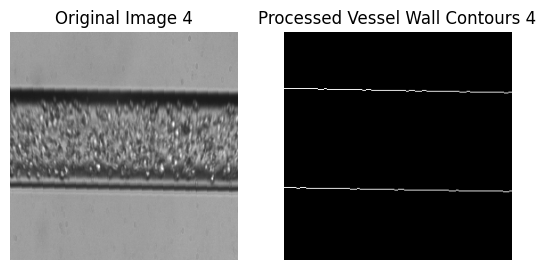

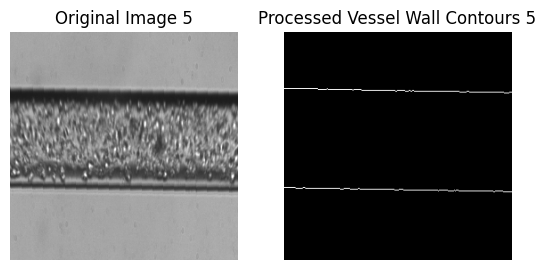

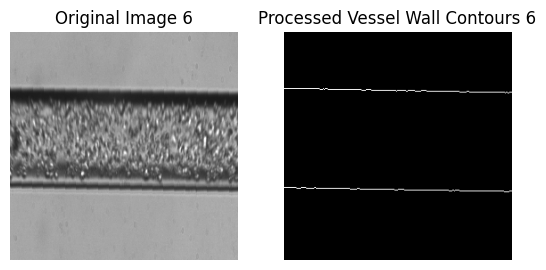

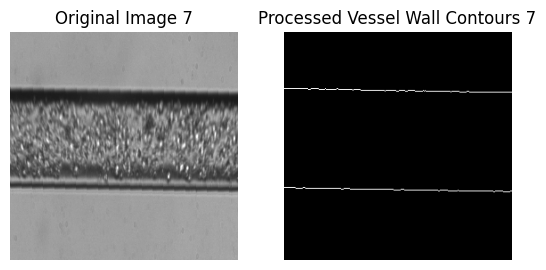

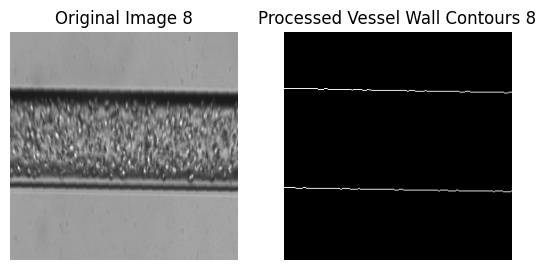

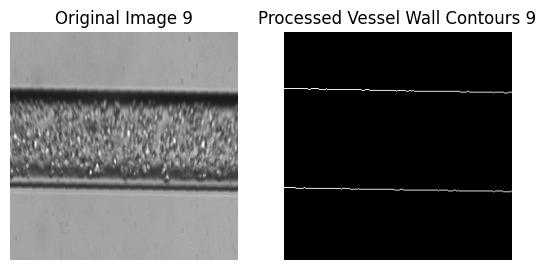

In [72]:
# Function to filter contours for straight lines
# Example modification to the contour filtering criteria
def filter_contours_for_straight_lines(contours, min_length=100, threshold=50):
    filtered_contours = []
    for contour in contours:
        # Consider using arcLength to filter based on contour length without assuming straightness
        if cv2.arcLength(contour, True) > min_length:
            filtered_contours.append(contour)
    return filtered_contours

def process_contour_image(contour_image):
    # Convert contour image to numpy array
    image_data = np.array(contour_image)

    # Apply threshold to get binary image
    thresholded = (image_data > 0) * 255

    # Find the first and last white pixel in each column
    first_white_pixels = np.argmax(thresholded, axis=0)
    last_white_pixels = thresholded.shape[0] - np.argmax(thresholded[::-1], axis=0) - 1

    # Create a new array to hold the processed image
    processed_image_data = np.zeros_like(image_data)

    # Mark only the first and last white pixel in the column as white
    for col in range(thresholded.shape[1]):
        if first_white_pixels[col] != 0 or last_white_pixels[col] != thresholded.shape[0] - 1:
            processed_image_data[first_white_pixels[col], col] = 255
            if first_white_pixels[col] != last_white_pixels[col]:  # If they are not the same pixel
                processed_image_data[last_white_pixels[col], col] = 255

    # Convert processed data back to an image
    processed_contour_image = Image.fromarray(processed_image_data.astype(np.uint8))
    return processed_contour_image, first_white_pixels, last_white_pixels


def find_wall(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the median pixel value of the grayscale image
    v = np.median(gray_image)

    # Set lower and upper thresholds for Canny dynamically
    sigma = 0.5
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))

    # Apply Gaussian blur
    # Adaptive kernel size based on image size (smaller images might need a smaller kernel)
    kernel_size = (3, 3) if image.shape[0] < 500 else (5, 5)

    # Apply Gaussian blur with adaptive kernel size
    blurred = cv2.GaussianBlur(gray_image, kernel_size, 0)

    # Apply Canny edge detection using Otsu's thresholds
    edges = cv2.Canny(blurred, lower, upper)

    # Use dilation to close gaps in the edges
    # Adjust dilation parameters
    kernel = np.ones((1, 1), np.uint8)  # Smaller kernel
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)


    # Find contours from the dilated Canny edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter for straight lines
    filtered_contours = filter_contours_for_straight_lines(contours)

    # Create an empty mask to draw the contours on
    vessel_wall_contours = np.zeros_like(gray_image)

    # Draw the filtered contours - this will be the vessel walls
    cv2.drawContours(vessel_wall_contours, filtered_contours, -1, (255), thickness=1)
    #vessel_wall_contours_resized = cv2.resize(vessel_wall_contours, (256, 256))

   # Convert the contours array to an image
    vessel_wall_contours_image = Image.fromarray(vessel_wall_contours)

    # Process the contour image with the provided function
    processed_vessel_wall_contours_image, first_white_pixels, last_white_pixels = process_contour_image(vessel_wall_contours_image)

    return np.array(processed_vessel_wall_contours_image), first_white_pixels, last_white_pixels



# Path to the directory containing input and output images
image_path = "/content/drive/MyDrive/CFL_training_data"

# Lists to store input and output images
input_images = []

# Load input and output images
for image_file in os.listdir(os.path.join(image_path, 'input'))[:10]:
    input_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'input', image_file)), (256, 256)))

# Process each input image
for i, image in enumerate(input_images):
    # Convert PIL image back to array for visualization and further processing if needed
    processed_vessel_wall_contours_array, first_white_pixels_wall, last_white_pixels_wall = find_wall(image)

    # Display the input image and the image with the vessel lines side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i}')
    plt.axis('off')

    # Image with vessel lines
    plt.subplot(1, 3, 2)
    plt.imshow(processed_vessel_wall_contours_array, cmap='gray')
    plt.title(f'Processed Vessel Wall Contours {i}')
    plt.axis('off')

    plt.show()

In [2]:
import tensorflow as tf

In [3]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CFL_training_data/final_attention_unet')

In [13]:
pred = model.predict(np.array(input_images))

1/1 [==============================] - 23s 23s/step


In [16]:
pred[0].shape

(256, 256, 1)

In [73]:
def find_closest_non_outlier(arr, index, outlier_indices):
    left_index = index - 1
    right_index = index + 1

    while left_index >= 0 or right_index < len(arr):
        if left_index >= 0 and not outlier_indices[left_index]:
            return arr[left_index]
        if right_index < len(arr) and not outlier_indices[right_index]:
            return arr[right_index]
        left_index -= 1
        right_index += 1

    # If no non-outlier value is found, return the mean of the array
    return np.mean(arr)

def replace_outliers(arr):
    # Calculate the mean and standard deviation of the array
    mean = np.mean(arr)
    std_dev = np.std(arr)

    # Define the threshold for identifying outliers
    threshold = 2.0  # You can adjust this value based on your data distribution

    # Find the indices of outliers
    outlier_indices = np.abs(arr - mean) > threshold * std_dev

    # Replace outliers with the closest non-outlier value
    for i in range(len(arr)):
        if outlier_indices[i]:
            arr[i] = find_closest_non_outlier(arr, i, outlier_indices)

    return arr

def mark_edge(white_pixel_array, image):
  for i, val in enumerate(white_pixel_array):
      image[val,i] = 1
  return image

def find_core(image):
  # Set lower and upper thresholds for Canny dynamically
  v = np.median(image)
  sigma = 0.5
  lower = int(max(0, (1.0 - sigma) * v))
  upper = int(min(255, (1.0 + sigma) * v))
  # Apply Canny edge detection using Otsu's thresholds

  edges = cv2.Canny(np.uint8((image>0.9)), lower, upper)
  first_white_pixels = np.argmax(edges, axis=0)
  fixed_first_white_pixels = replace_outliers(first_white_pixels)
  last_white_pixels = edges.shape[0] - np.argmax(edges[::-1], axis=0) - 1
  fixed_last_white_pixels = replace_outliers(last_white_pixels)
  return fixed_first_white_pixels, fixed_last_white_pixels

In [75]:
for i, (input_img, pred_img) in enumerate(zip(np.array(input_images),pred)):
  wall_image, first_white_pixels_wall, last_white_pixels_wall = find_wall(input_img)
  pred_img = pred_img[..., 0]
  first_white_pixels_core, last_white_pixels_core = find_core(pred_img)
  distance_top = np.abs(first_white_pixels_wall - first_white_pixels_core)
  distance_bottom = np.abs(last_white_pixels_core - last_white_pixels_wall)
  print(distance_top)
  print(distance_bottom)

[25 25 23 23 22 22 21 21 21 21 21 22 22 23 23 22 21 19 19 18 18 18 19 19
 20 22 23 23 23 24 22 21 21 20 20 20 21 21 20 20 20 20 20 20 21 21 22 22
 21 22 22 23 24 25 25 24 23 21 21 20 20 19 19 19 20 20 21 21 21 21 21 21
 21 22 22 23 24 23 23 23 22 21 21 20 21 21 21 20 20 20 20 20 20 19 19 20
 19 19 18 19 19 20 20 20 20 20 20 19 19 18 18 18 17 17 18 18 19 19 31 32
 31 24 22 22 21 21 19 19 19 19 19 20 21 22 22 22 21 20 19 18 18 18 18 19
 19 20 20 19 19 19 19 18 18 17 17 17 17 17 19 18 18 18 18 19 19 19 19 19
 18 18 17 17 17 17 17 17 17 18 18 19 21 24 25 26 26 24 22 21 20 19 19 18
 18 18 18 19 20 21 22 22 21 19 18 17 17 18 18 20 20 22 23 24 24 24 23 22
 20 19 19 18 18 17 17 17 17 17 17 17 17 17 18 18 19 19 19 19 19 18 17 17
 17 17 18 19 21 24 25 24 23 22 20 17 17 18 18 18]
[28 28 26 25 24 24 23 23 23 24 25 27 25 16 14 12 12 12 12 12 12 13 14 17
 21 22 23 24 24 24 24 25 25 25 24 20 19 19 19 15 13 11 11 11 11 11 12 15
 17 18 19 18 18 18 18 18 18 18 19 20 20 20 20 19 18 16 14 13 13 12 12 12
 